In [40]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
import tensorflow as tf
#Function import
from ipynb.fs.full.autoXRD import normdata
from ipynb.fs.full.autoXRD import normdatasingle
from ipynb.fs.full.autoXRD import augdata
from ipynb.fs.full.autoXRD import exp_augdata
from ipynb.fs.full.autoXRD import exp_data_processing

In [41]:
theor = pd.read_csv('Datasets/theor.csv', index_col=0)
print(theor.shape)
theor = theor.iloc[1:,]
theor_arr = theor.values
print(theor_arr.shape)

# Normalize data for training
ntheor = normdata(theor_arr)

#exp = pd.read_csv('Datasets/exp.csv', index_col=0)
#exp_arr = exp.values
#print(exp_arr.shape)

(2402, 1468)
(2401, 1468)


In [3]:
label_theo = pd.read_csv('Datasets/label_theo.csv', header=None, index_col=0)
label_theo = label_theo[1].tolist()

# Load experimental class labels
#label_exp= pd.read_csv('Datasets/label_theo.csv', index_col=0).values
#label_exp = label_exp.reshape([len(label_exp),])

space_group_enc = pd.read_csv('Datasets/encoding.csv', index_col=0)
space_group_enc = list(space_group_enc['0'])

# Enconde theoretical labels
label_t=np.zeros([len(label_theo),])
for i in range(len(label_theo)):
    label_t[i]=space_group_enc.index(label_theo[i])
    
print(label_t.shape)

(734,)


In [4]:
#prepare X et Y
X_th = np.transpose(ntheor)
X_th = X_th.reshape(734, 2401, 1)
Y_th = label_t

X_th = X_th.astype(np.float32)
Y_th = Y_th.astype(np.float32)

print(X_th.shape)
print(Y_th.shape)

(734, 2401, 1)
(734,)


In [5]:
# Introduction de set de test à partir de la base de données
# Definition du set de test 20% d'images random
# Avec cette ligne on definit set de images et targets pour l'entrainement et test
X_th_train, X_th_valid, Y_th_train, Y_th_valid = train_test_split(X_th, Y_th, test_size=0.2, random_state=1)

print("X_th_train", X_th_train.shape)
print("X_th_valid", X_th_valid.shape)

print("Y_th_train", Y_th_train.shape)
print("Y_th_valid", Y_th_valid.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((X_th, Y_th))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_th_valid, Y_th_valid))

print(train_dataset)
print(valid_dataset)

X_th_train (587, 2401, 1)
X_th_valid (147, 2401, 1)
Y_th_train (587,)
Y_th_valid (147,)
<TensorSliceDataset shapes: ((2401, 1), ()), types: (tf.float32, tf.float32)>
<TensorSliceDataset shapes: ((2401, 1), ()), types: (tf.float32, tf.float32)>


In [6]:
# Iter in the dataset with a number of epoch and batch size
epoch = 1
batch_size = 32
for X_th_batch, Y_th_batch in train_dataset.repeat(epoch).batch(batch_size):
    print(X_th_batch.shape, Y_th_batch.shape)
    break

(32, 2401, 1) (32,)


In [7]:
class ConvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        # Convolutions
        self.conv1 = tf.keras.layers.Conv1D(32, 8, activation='relu', name="conv1")
        self.conv2 = tf.keras.layers.Conv1D(64, 5, activation='relu', name="conv2")
        self.conv3 = tf.keras.layers.Conv1D(128, 3, activation='relu', name="conv3")
        # Flatten the convolution
        self.flatten = tf.keras.layers.Flatten(name="flatten")       
        # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
        self.out = tf.keras.layers.Dense(4, activation='softmax', name="output")

    def call(self, X_th):
        conv1 = self.conv1(X_th)
        #print(conv1)
        conv2 = self.conv2(conv1)
        #print(conv2)
        conv3 = self.conv3(conv2)
        #print(conv3)
        flatten = self.flatten(conv3)
        #print(flatten)
        d1 = self.d1(flatten)
        #print(d1)
        output = self.out(d1)
        return output

model = ConvModel()
#model.predict(X_th[:,:,:])

In [8]:
#Define loss, optimizer, accuracy for th emodel to compile
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [9]:
# Definition de la fonction qui va entrainer le modele
# On utilise un graphe @
@tf.function
def train_step(X_th, Y_th):
    # Calcul du gradient
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(X_th)
        # Get the error/loss on these predictions
        loss = loss_object(Y_th, predictions)
    # Compute the gradient which respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(Y_th, predictions)

In [10]:
# Methode de validation en mode graphe
@tf.function
def valid_step(X_th, Y_th):
    predictions = model(X_th)
    t_loss = loss_object(Y_th, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(Y_th, predictions)

In [11]:
#Iteration du modele
epoch = 20
batch_size = 32
b = 0 #Compter les batchs
for epoch in range(epoch):
    # Training set
    for X_th_batch, Y_th_batch in train_dataset.batch(batch_size): #Iteration dans la dataset
        train_step(X_th_batch, Y_th_batch) #On lance un entrainement
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(Y_th), train_loss.result(), 
            train_accuracy.result()*100
        ), end="") #Informations de l'entrainement
        b += batch_size
    # Validation set
    for X_th_batch, Y_th_batch in valid_dataset.batch(batch_size):
        valid_step(X_th_batch, Y_th_batch) #Mesure precision sur chacun des batch

    template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(
        epoch+1,
        valid_loss.result(), 
        valid_accuracy.result()*100)
    )
    #A la fin de chaque epoch on vide
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()

 Batch 704/734, Loss: 1.2943474054336548, Accuracy: 52.997272491455084
Epoch 1, Valid Loss: 0.9558969736099243, Valid Accuracy: 61.904762268066406
 Batch 1440/734, Loss: 0.9187923073768616, Accuracy: 64.57765960693368
Epoch 2, Valid Loss: 0.6648992896080017, Valid Accuracy: 71.42857360839844
 Batch 2176/734, Loss: 0.6389651894569397, Accuracy: 73.02452087402344
Epoch 3, Valid Loss: 0.3951786160469055, Valid Accuracy: 87.7551040649414
 Batch 2912/734, Loss: 0.36976128816604614, Accuracy: 86.92098236083984
Epoch 4, Valid Loss: 0.15913176536560059, Valid Accuracy: 95.23809814453125
 Batch 3648/734, Loss: 0.1656179577112198, Accuracy: 93.732971191406254
Epoch 5, Valid Loss: 0.1098840981721878, Valid Accuracy: 96.59864044189453
 Batch 4384/734, Loss: 0.13182508945465088, Accuracy: 95.23161315917969
Epoch 6, Valid Loss: 0.05805634707212448, Valid Accuracy: 97.95918273925781
 Batch 5120/734, Loss: 0.08969826996326447, Accuracy: 97.13896179199219
Epoch 7, Valid Loss: 0.08115655183792114, Valid

In [12]:
res = model.predict(X_th[:,:,:])
print(res.shape)
for i in range(723, 733):
    print(res[i], label_theo[i])

(734, 4)
[3.5793834e-15 5.5501037e-06 2.3997583e-08 9.9999440e-01] 3D
[4.4858527e-19 5.7584984e-08 9.0900736e-09 9.9999988e-01] 3D
[2.9611351e-06 1.2597246e-03 8.0004502e-03 9.9073690e-01] 3D
[1.2703511e-07 5.9606042e-04 1.1522410e-03 9.9825150e-01] 3D
[8.7240996e-06 6.9555023e-04 5.1242290e-03 9.9417144e-01] 3D
[8.6193797e-10 8.8563934e-04 1.0771669e-03 9.9803716e-01] 3D
[6.4659297e-14 1.6277518e-05 7.0273286e-06 9.9997675e-01] 3D
[5.1344613e-09 3.1682817e-04 5.1737158e-04 9.9916577e-01] 3D
[1.3538132e-16 3.9038142e-08 1.4572299e-05 9.9998534e-01] 3D
[4.5449973e-29 2.7024505e-09 2.3930886e-16 1.0000000e+00] 3D


(4305, 136)


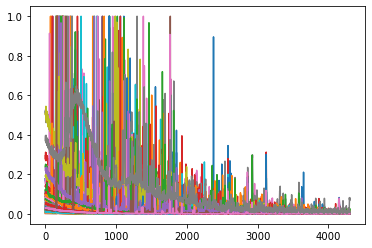

(4305, 68)


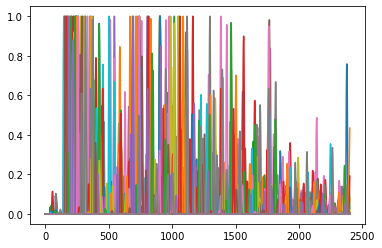

(2401, 68)


In [38]:
#Load experimental data as dataframe
exp = pd.read_csv('Datasets/exp.csv', index_col=0)
exp_arr = exp.values
print(exp_arr.shape)

#Normalisation
nexp = normdata(exp_arr)
plt.plot(nexp)
plt.show()
print(nexp.shape)

# Process data experimental
# Define spectral range for data
exp_min = 0
exp_max = 2401 
theor_min = 125

#window size for experimental data extraction
window = 20
theor_max = theor_min+exp_max-exp_min

# Preprocess experimental data
post_exp = normdatasingle(exp_data_processing (nexp, exp_min, exp_max, window))
plt.plot(post_exp)
plt.show()

print(post_exp.shape)
# Specify how many data points we augmented
#th_num = 734

# Augment data, this may take a bit
#augd,pard,crop_augd = augdata(ntheor, th_num, label_theo, theor_min, theor_max)

#prepare arrays
X_exp = np.transpose(post_exp)
X_exp = X_exp.reshape(68, 2401, 1)

X_exp = X_exp.astype(np.float32)

In [39]:
model.predict(X_exp[:,:,:])

array([[7.82193619e-21, 1.83149177e-06, 9.99955058e-01, 4.31426342e-05],
       [1.22435250e-14, 1.54223318e-11, 1.00000000e+00, 4.43508908e-15],
       [1.87399056e-08, 9.97740030e-01, 2.25930824e-03, 7.13522581e-07],
       [1.72702180e-18, 1.29998489e-06, 9.99875903e-01, 1.22788537e-04],
       [1.99833010e-12, 7.65390529e-10, 1.00000000e+00, 9.85423271e-11],
       [3.99360154e-03, 4.46548889e-04, 9.95174110e-01, 3.85831489e-04],
       [4.61592025e-21, 3.67342224e-13, 1.00000000e+00, 2.45570370e-10],
       [8.12454455e-05, 9.99882460e-01, 3.62846222e-05, 2.58168959e-17],
       [8.32157429e-21, 1.51357038e-10, 1.00000000e+00, 7.03873237e-10],
       [1.42370888e-08, 8.04310858e-08, 9.99999881e-01, 8.49957882e-11],
       [2.25349581e-07, 9.99999642e-01, 1.76655902e-07, 7.08909375e-21],
       [5.39307599e-10, 9.96547401e-01, 3.45256506e-03, 9.52872803e-09],
       [2.90826887e-01, 5.06618619e-03, 7.04106927e-01, 7.91095245e-11],
       [2.53658813e-12, 2.04612320e-06, 9.99997973e